In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import attention_conv.model as modelsrc
# import unet.model as modelsrc
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os
import imp
import pickle
from datetime import datetime

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
imp.reload(modelsrc)
ModelToTest = modelsrc.AttentionConv
params = []

Setup dataset and dataloader

In [17]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)

Training Setup

In [4]:
BATCH_LEN = 4 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [5]:
# cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

NameError: name 'dataset' is not defined

In [6]:
# model = ModelToTest()

Training utilities
# wow

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

NameError: name 'model' is not defined

Training loop definition

In [5]:
dir_to_save = 'conv_concept_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [6]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list):
    its_til_checkpoint = 20
    its_til_update = 4
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    model.train()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))
            name_list.append(file_name)

            running_loss = 0
            count = 0
            
        if i == 240: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [21]:
# losses = []
# train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'cl_loader' is not defined

In [7]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    name_list = []
    try:
        for epoch in range(epochs):
            print(f'Entering epoch {epoch}')
            train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list)
            print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
            plt.plot(epoch_losses, 'r-')
            plt.title('Epoch Losses')
            plt.show()

            #remove old entries
            for name in name_list[:-5]:
                path = os.path.join(dir_to_save, name)
                if os.path.isfile(path):
                    os.remove(path)
            name_list = name_list[-5:]

            with open(os.path.join(dir_to_save, 'epoch_losses'), 'wb') as f:
                pickle.dump(epoch_losses, f)
            f.close()
    except Exception as e: #catch any error and log em!
        with open(os.path.join(dir_to_save, 'error.txt'), 'a') as f:
            f.write(str(e))
        f.close()
    
    # time of finish
    with open(os.path.join(dir_to_save, 'time_of_finish.txt'), 'a') as f:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        f.write(dt_string)
    f.close()
    
    return losses

In [8]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

In [9]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ModelToTest()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
msssim = MS_SSIMLoss(channels=24)
l1 = torch.nn.L1Loss()
criterion = lambda pred, target: msssim(pred,target) #+ l1(pred,target) 

In [ ]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

Entering epoch 0
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4


#### Lets see the results


tensor([[184.9467, 179.6515, 184.8511,  ..., 187.1979, 185.3930, 186.9064],
        [180.4158, 184.2604, 181.9316,  ..., 183.3982, 183.4162, 185.8605],
        [182.5462, 180.1273, 180.6724,  ..., 184.4488, 187.7511, 184.9675],
        ...,
        [181.3235, 183.3614, 181.5061,  ..., 183.8845, 182.7938, 186.6209],
        [184.0919, 182.2409, 182.6602,  ..., 187.2393, 185.1724, 185.4053],
        [183.5573, 179.1617, 181.6473,  ..., 185.1208, 183.8480, 184.3917]])
tensor([[184.9473, 179.6512, 184.8512,  ..., 187.1979, 185.3929, 186.9064],
        [180.4161, 184.2605, 181.9317,  ..., 183.3982, 183.4161, 185.8607],
        [182.5455, 180.1272, 180.6727,  ..., 184.4490, 187.7511, 184.9675],
        ...,
        [181.3235, 183.3615, 181.5058,  ..., 183.8843, 182.7939, 186.6210],
        [184.0918, 182.2410, 182.6603,  ..., 187.2393, 185.1724, 185.4053],
        [183.5571, 179.1617, 181.6473,  ..., 185.1208, 183.8479, 184.3916]])
tensor([[184.9482, 179.6510, 184.8512,  ..., 187.1978, 185.3

tensor([[184.9467, 179.6515, 184.8511,  ..., 187.1979, 185.3930, 186.9064],
        [180.4158, 184.2604, 181.9316,  ..., 183.3982, 183.4161, 185.8605],
        [182.5462, 180.1273, 180.6723,  ..., 184.4489, 187.7511, 184.9675],
        ...,
        [181.3235, 183.3614, 181.5060,  ..., 183.8845, 182.7938, 186.6209],
        [184.0918, 182.2409, 182.6602,  ..., 187.2393, 185.1724, 185.4053],
        [183.5573, 179.1616, 181.6473,  ..., 185.1208, 183.8479, 184.3917]])
tensor([[184.9473, 179.6512, 184.8512,  ..., 187.1979, 185.3929, 186.9064],
        [180.4160, 184.2605, 181.9317,  ..., 183.3982, 183.4161, 185.8606],
        [182.5455, 180.1272, 180.6727,  ..., 184.4490, 187.7512, 184.9674],
        ...,
        [181.3235, 183.3615, 181.5058,  ..., 183.8843, 182.7939, 186.6210],
        [184.0918, 182.2411, 182.6602,  ..., 187.2393, 185.1723, 185.4053],
        [183.5571, 179.1617, 181.6473,  ..., 185.1208, 183.8479, 184.3916]])
tensor([[184.9483, 179.6511, 184.8512,  ..., 187.1978, 185.3

tensor([[184.9467, 179.6515, 184.8511,  ..., 187.1979, 185.3929, 186.9064],
        [180.4158, 184.2605, 181.9315,  ..., 183.3982, 183.4161, 185.8605],
        [182.5462, 180.1273, 180.6723,  ..., 184.4488, 187.7511, 184.9675],
        ...,
        [181.3235, 183.3614, 181.5061,  ..., 183.8844, 182.7938, 186.6209],
        [184.0919, 182.2409, 182.6603,  ..., 187.2393, 185.1724, 185.4053],
        [183.5573, 179.1617, 181.6474,  ..., 185.1208, 183.8479, 184.3917]])
tensor([[184.9473, 179.6512, 184.8512,  ..., 187.1979, 185.3929, 186.9064],
        [180.4161, 184.2604, 181.9317,  ..., 183.3982, 183.4161, 185.8607],
        [182.5455, 180.1272, 180.6727,  ..., 184.4490, 187.7512, 184.9675],
        ...,
        [181.3235, 183.3616, 181.5059,  ..., 183.8844, 182.7939, 186.6210],
        [184.0918, 182.2410, 182.6602,  ..., 187.2394, 185.1724, 185.4053],
        [183.5571, 179.1617, 181.6473,  ..., 185.1208, 183.8479, 184.3916]])
tensor([[184.9482, 179.6511, 184.8512,  ..., 187.1978, 185.3

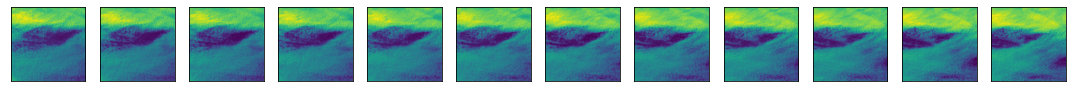

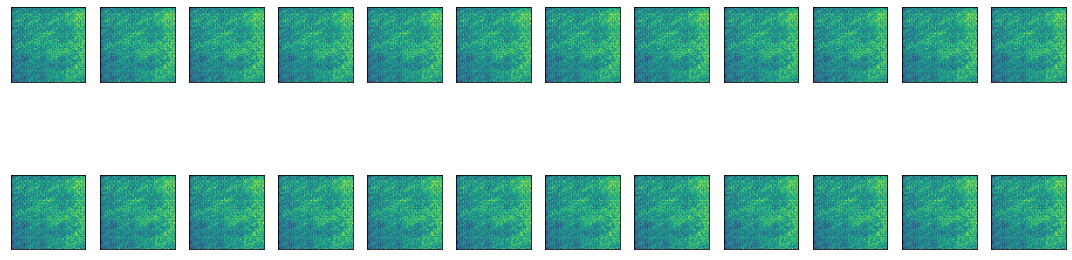

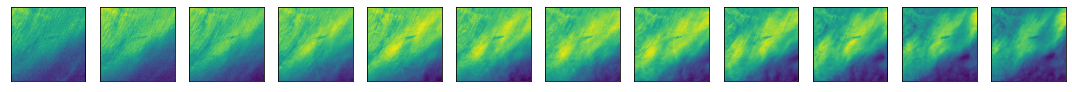

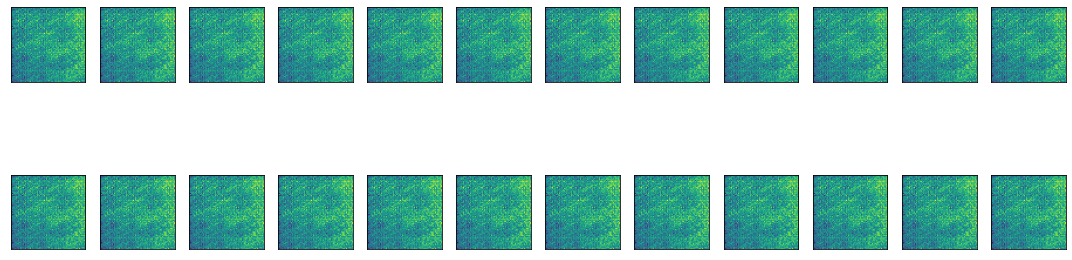

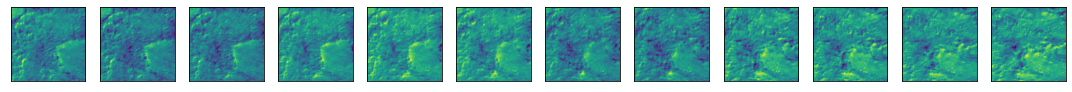

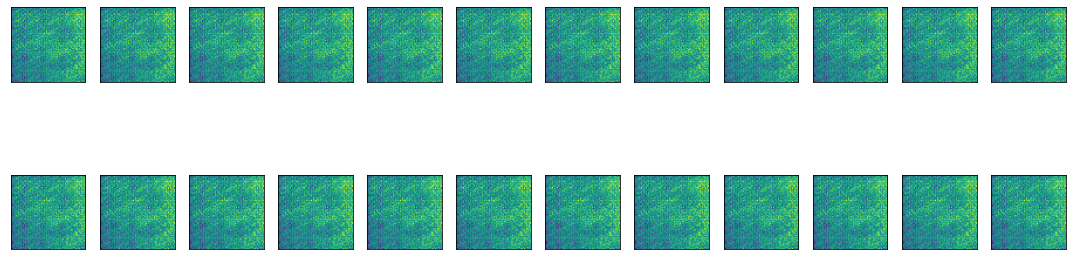

In [12]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 6:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [11]:
model.load_state_dict(torch.load(os.path.join(dir_to_save, 'epoch-1_iteration-219_loss-0.23476462662220002')))

<All keys matched successfully>

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()